## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipaddress

from IPython.display import display
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, average_precision_score, ConfusionMatrixDisplay, roc_curve, auc, PrecisionRecallDisplay

rng = np.random.RandomState(42)


## Data loading

In [2]:
col_names = ['end_epoch', 'duration', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flags', 'status', 'service_type', 'packets', 'bytes', 'attack']

def load_dataframe(name):
    return pd.read_csv(f"data/training/{name}_flows_cut.csv", header = None, names = col_names)

def load_test_dataframe(name):
    return pd.read_csv(f"data/test/{name}_flows_cut.csv", header = None, names = col_names)

In [3]:
# Load training datasets
background = load_dataframe("background")
blacklist  = load_dataframe("blacklist")
sshscan    = load_dataframe("sshscan")
spam       = load_dataframe("spam")

# Load tests datasets
test_background = load_test_dataframe("background")
test_blacklist  = load_test_dataframe("blacklist")
test_sshscan    = load_test_dataframe("sshscan")
test_botnet     = load_test_dataframe("botnet")
test_scan11     = load_test_dataframe("scan11")
test_scan44     = load_test_dataframe("scan44")
test_spam       = load_test_dataframe("spam")
test_dos        = load_test_dataframe("dos")

# We regroup all attacks of each dataset in lists to have a cleaner code latter
attacks_dataframes = [blacklist, sshscan, spam]
test_attacks_dataframes = [test_blacklist, test_sshscan, test_botnet, test_scan11, test_scan44, test_spam, test_dos]

In [4]:
def get_dataframes(outlier_ratio, num_samples):
    """
    This function allow us to get two proper datasets of training and tests with the given size and outlier ratio.
    """
    # Set offsets of each dataset depending on poor sized sub-datasets
    train_offset = len(spam) % num_samples * outlier_ratio
    test_offset = len(test_sshscan) % num_samples * outlier_ratio

    # Get the number of attack sample our datasets will contains
    nb_train_attack = int((num_samples * outlier_ratio - train_offset) // (len(attacks_dataframes) - 1))
    nb_test_attack  = int((num_samples * outlier_ratio - test_offset) // (len(test_attacks_dataframes) - 1))

    # Get the correct number of sample for each attack sub-dataset
    train_dataframes = [df.head(nb_train_attack) for df in attacks_dataframes]
    test_dataframes = [df.head(nb_test_attack) for df in test_attacks_dataframes]

    # The remaining of space allowed is fill with background flows for each dataset
    train_dataframes.append(background.head(num_samples - sum(len(df) for df in train_dataframes)))
    test_dataframes.append(test_background.head(num_samples - sum(len(df) for df in test_dataframes)))

    # Concat each lists to get our dataframes
    train_df = pd.concat(train_dataframes, ignore_index=True)
    test_df = pd.concat(test_dataframes, ignore_index=True)

    return train_df, test_df

In [5]:
outlier_ratio = 0.1
train_df, test_df = get_dataframes(outlier_ratio, 10000)
train_df.head()

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,protocol,flags,status,service_type,packets,bytes,attack
0,2016-04-18 00:02:16,0.996,42.219.158.242,60.56.180.24,33421,80,TCP,.AP.SF,0,0,6,437,blacklist
1,2016-04-18 00:02:16,0.852,42.219.158.242,60.56.180.24,35297,443,TCP,.AP.SF,0,0,52,3030,blacklist
2,2016-04-18 00:02:17,0.936,60.56.180.24,42.219.158.242,80,33421,TCP,.AP.SF,0,0,4,565,blacklist
3,2016-04-18 00:02:17,0.804,60.56.180.24,42.219.158.242,443,35297,TCP,.AP.SF,0,0,72,86267,blacklist
4,2016-04-18 00:02:30,0.000,42.219.152.242,88.205.102.190,38531,25,TCP,....S.,0,0,1,60,blacklist


## Data analysis

As described in the scientific paper, we know that our 'background' data may contain unlabeled attacks.  
Because we cant know for sure which exchanges are attacks we'll consider them as geniune exchanges for now.  
Same goes for blacklist flows, we cant know for sure if they are attacks we'll consider them as fraudulent exchanges for now.  

### Training dataset observations

In [6]:
print(f'The training dataset size is: {len(train_df)}\n')

print(f'The number of unknown attacks / background exchanges is: {len(train_df[train_df.attack == "background"])}')
print(f'The number of known attacks is: {len(train_df[train_df.attack != "background"])}\n')

print(f'The types of attack are: {train_df[train_df.attack != "background"].attack.unique()}')
for attack in train_df[train_df.attack != "background"].attack.unique():
    print(f'The number of {attack} is: {len(train_df[train_df.attack == attack])}')
print()

print(f'Number of source IP used in known attacks: {len(train_df[train_df.attack != "background"].src_ip.unique())}')
print(f'Number of source IP used in othe exchanges: {len(train_df[train_df.attack == "background"].src_ip.unique())}')
print(f'Number of destination IP used in known attacks: {len(train_df[train_df.attack != "background"].dst_ip.unique())}')
print(f'Number of destination IP used in other exchanges: {len(train_df[train_df.attack == "background"].dst_ip.unique())}\n')

print(f'Number of source port used in known attacks: {len(train_df[train_df.attack != "background"].src_port.unique())}')
print(f'Number of source port used in othe exchanges: {len(train_df[train_df.attack == "background"].src_port.unique())}')
print(f'Number of destination port used in known attacks: {len(train_df[train_df.attack != "background"].dst_port.unique())}')
print(f'Number of destination port used in othe exchanges: {len(train_df[train_df.attack == "background"].dst_port.unique())}\n')

print(f'Protocols used during known attacks: {train_df[train_df.attack != "background"].protocol.unique()}')
print(f'Protocols used during other exchanges: {train_df[train_df.attack == "background"].protocol.unique()}\n')

The training dataset size is: 10000

The number of unknown attacks / background exchanges is: 8965
The number of known attacks is: 1035

The types of attack are: ['blacklist' 'anomaly-sshscan' 'anomaly-spam']
The number of blacklist is: 497
The number of anomaly-sshscan is: 497
The number of anomaly-spam is: 41

Number of source IP used in known attacks: 251
Number of source IP used in othe exchanges: 2018
Number of destination IP used in known attacks: 227
Number of destination IP used in other exchanges: 1537

Number of source port used in known attacks: 451
Number of source port used in othe exchanges: 4363
Number of destination port used in known attacks: 495
Number of destination port used in othe exchanges: 3939

Protocols used during known attacks: ['TCP' 'UDP' 'ICMP']
Protocols used during other exchanges: ['TCP' 'UDP' 'GRE' 'ESP' 'ICMP' 'IPv6']



In [7]:
print(f'Flags used during known attacks: {train_df[train_df.attack != "background"]["flags"].unique()}')
print(f'Flags used during other exchanges: {train_df[train_df.attack == "background"]["flags"].unique()}\n')

print(f'Types of service used during known attacks: {train_df[train_df.attack != "background"].service_type.unique()}')
print(f'Types of service used during other exchanges: {train_df[train_df.attack == "background"].service_type.unique()}\n')

print(f'Number of different status in the dataset: {len(train_df.status.unique())}\n')

print('Details of quantitative features of known attacks:')
display(train_df[train_df.attack != "background"][['duration', 'packets', 'bytes']].describe())
print()
print('Details of quantitative features of other exchanges:')
display(train_df[train_df.attack == "background"][['duration', 'packets', 'bytes']].describe())

Flags used during known attacks: ['.AP.SF' '....S.' '.A.R..' '.AP.S.' '.A...F' '.A....' '.A..SF' '.APRSF'
 '.A..S.' '.AP..F' '.AP...' '.APR.F' '...R..' '.APRS.' '...RS.']
Flags used during other exchanges: ['.A....' '.A..S.' '.AP.S.' '.AP...' '....S.' '.A...F' '.A.R.F' '.APR..'
 '.A.R..' '.AP..F' '...R..' '.AP.SF' '.A..SF' '.APRS.' '.APRSF' '.A.RSF'
 '.APR.F' '.A.RS.']

Types of service used during known attacks: [ 0 40 72  8]
Types of service used during other exchanges: [  0  64  40  72   2   8 192  26  24 200  80  42 184  16 104  20  75]

Number of different status in the dataset: 1

Details of quantitative features of known attacks:


,duration,packets,bytes
count,1035.000000,1035.000000,1.035000e+03
mean,4.668881,24.860870,1.485774e+04
std,5.745437,63.051175,7.601059e+04
min,0.000000,1.000000,4.000000e+01
25%,0.888000,5.000000,5.650000e+02
50%,3.540000,12.000000,1.373000e+03
75%,5.040000,15.000000,1.954000e+03
max,54.712000,782.000000,1.118209e+06



Details of quantitative features of other exchanges:


,duration,packets,bytes
count,8965.000000,8965.000000,8.965000e+03
mean,1.109757,15.008589,7.854498e+03
std,5.411496,374.938073,2.400408e+05
min,0.000000,1.000000,3.100000e+01
25%,0.000000,1.000000,7.600000e+01
50%,0.000000,1.000000,1.310000e+02
75%,0.324000,6.000000,7.280000e+02
max,194.796000,29544.000000,1.765682e+07


array([[<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'src_port'}>,
        <AxesSubplot:title={'center':'dst_port'}>],
       [<AxesSubplot:title={'center':'status'}>,
        <AxesSubplot:title={'center':'service_type'}>,
        <AxesSubplot:title={'center':'packets'}>],
       [<AxesSubplot:title={'center':'bytes'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

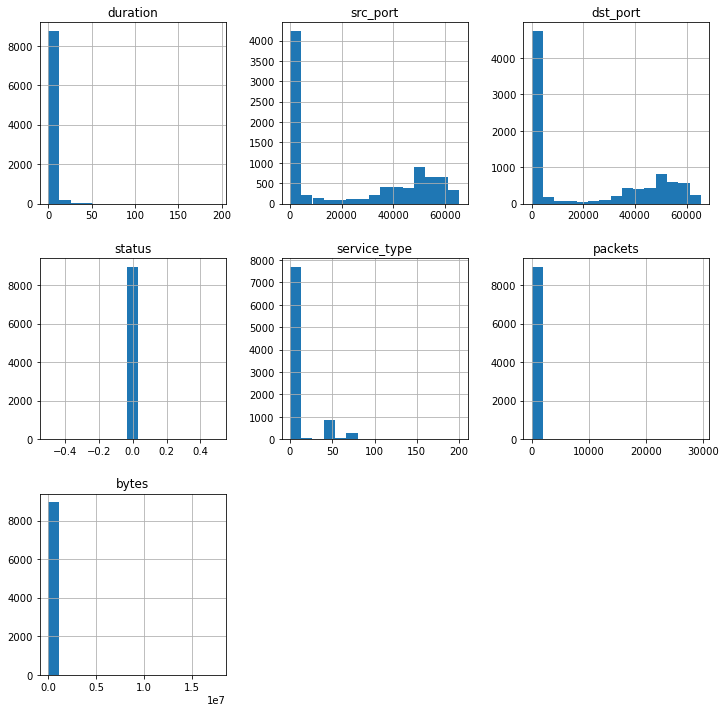

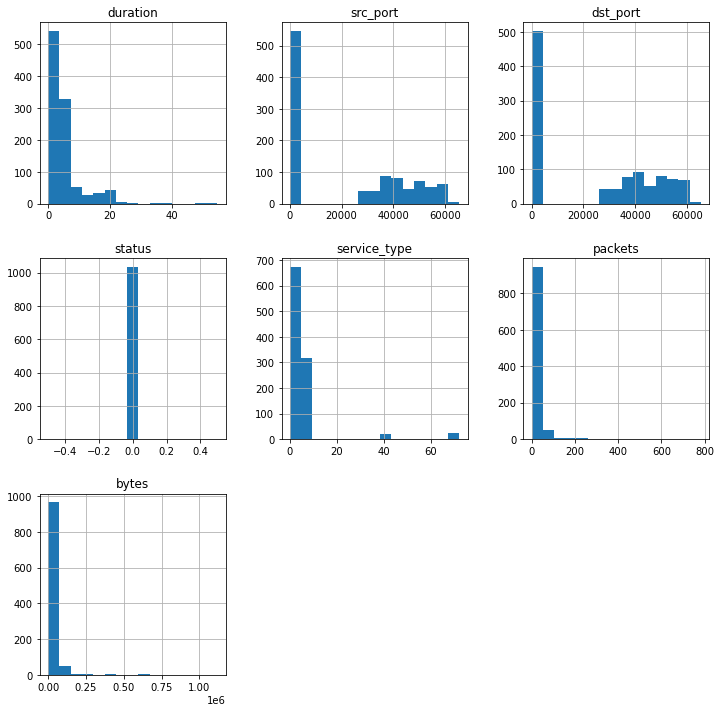

In [8]:
train_df[train_df.attack == "background"].hist(bins=15, figsize=(12, 12))
train_df[train_df.attack != "background"].hist(bins=15, figsize=(12, 12))

### Test Dataset observations

In [9]:
print(f'The test dataset size is: {len(test_df)}\n')

print(f'The number of unknown attacks / background exchanges is: {len(test_df[test_df.attack == "background"])}')
print(f'The number of known attacks is: {len(test_df[test_df.attack != "background"])}\n')

print(f'The types of attack are: {test_df[test_df.attack != "background"].attack.unique()}')
for attack in test_df[test_df.attack != "background"].attack.unique():
    print(f'The number of {attack} is: {len(test_df[test_df.attack == attack])}')
print()

print(f'Number of source IP used in known attacks: {len(test_df[test_df.attack != "background"].src_ip.unique())}')
print(f'Number of source IP used in othe exchanges: {len(test_df[test_df.attack == "background"].src_ip.unique())}')
print(f'Number of destination IP used in known attacks: {len(test_df[test_df.attack != "background"].dst_ip.unique())}')
print(f'Number of destination IP used in other exchanges: {len(test_df[test_df.attack == "background"].dst_ip.unique())}\n')

print(f'Number of source port used in known attacks: {len(test_df[test_df.attack != "background"].src_port.unique())}')
print(f'Number of source port used in othe exchanges: {len(test_df[test_df.attack == "background"].src_port.unique())}')
print(f'Number of destination port used in known attacks: {len(test_df[test_df.attack != "background"].dst_port.unique())}')
print(f'Number of destination port used in othe exchanges: {len(test_df[test_df.attack == "background"].dst_port.unique())}\n')

print(f'Protocols used during known attacks: {test_df[test_df.attack != "background"].protocol.unique()}')
print(f'Protocols used during other exchanges: {test_df[test_df.attack == "background"].protocol.unique()}\n')

The test dataset size is: 10000

The number of unknown attacks / background exchanges is: 8999
The number of known attacks is: 1001

The types of attack are: ['blacklist' 'anomaly-sshscan' 'nerisbotnet' 'scan11' 'scan44'
 'anomaly-spam' 'dos']
The number of blacklist is: 166
The number of anomaly-sshscan is: 5
The number of nerisbotnet is: 166
The number of scan11 is: 166
The number of scan44 is: 166
The number of anomaly-spam is: 166
The number of dos is: 166

Number of source IP used in known attacks: 131
Number of source IP used in othe exchanges: 1603
Number of destination IP used in known attacks: 50
Number of destination IP used in other exchanges: 3311

Number of source port used in known attacks: 515
Number of source port used in othe exchanges: 4455
Number of destination port used in known attacks: 274
Number of destination port used in othe exchanges: 3838

Protocols used during known attacks: ['TCP' 'UDP' 'ICMP']
Protocols used during other exchanges: ['ICMP' 'TCP' 'UDP']



In [10]:
print(f'Flags used during known attacks: {test_df[test_df.attack != "background"]["flags"].unique()}')
print(f'Flags used during other exchanges: {test_df[test_df.attack == "background"]["flags"].unique()}\n')

print(f'Types of service used during known attacks: {test_df[test_df.attack != "background"].service_type.unique()}')
print(f'Types of service used during other exchanges: {test_df[test_df.attack == "background"].service_type.unique()}\n')

print(f'Number of different status in the dataset: {len(test_df.status.unique())}\n')

print('Details of quantitative features of known attacks:')
display(test_df[test_df.attack != "background"][['duration', 'packets', 'bytes']].describe())
print()
print('Details of quantitative features of other exchanges:')
display(test_df[test_df.attack == "background"][['duration', 'packets', 'bytes']].describe())

Flags used during known attacks: ['.APRS.' '.AP.S.' '.APR..' '.AP.SF' '.A..SF' '....S.' '.APRSF' '.A.R..'
 '.A....' '.A.RSF' '...R..' '.AP..F' '.A..S.' '...RS.']
Flags used during other exchanges: ['.A....' '.A..S.' '....S.' '.A...F' '.A.R..' '.APR..' '.AP...' '...R..'
 '.AP.S.' '.A.RS.' '.A..SF' '.AP.SF' '.APR.F' '.APRSF' '.AP..F' '.APRS.'
 '.A.R.F' '...RS.']

Types of service used during known attacks: [40  0 72  8 74]
Types of service used during other exchanges: [192   0 200  26   2  64  24  72  40   4   8  20  16]

Number of different status in the dataset: 1

Details of quantitative features of known attacks:


,duration,packets,bytes
count,1001.000000,1001.000000,1001.000000
mean,0.779888,3.335664,634.646354
std,2.593195,3.860987,2776.405061
min,0.000000,1.000000,28.000000
25%,0.000000,1.000000,44.000000
50%,0.000000,2.000000,197.000000
75%,0.576000,6.000000,441.000000
max,21.060000,27.000000,36132.000000



Details of quantitative features of other exchanges:


,duration,packets,bytes
count,8999.000000,8999.000000,8.999000e+03
mean,1.431335,7.270252,4.047749e+03
std,5.636508,31.983570,4.009776e+04
min,0.000000,1.000000,2.800000e+01
25%,0.000000,1.000000,9.600000e+01
50%,0.200000,2.000000,1.640000e+02
75%,1.828000,7.000000,1.081500e+03
max,280.620000,1879.000000,2.703238e+06


array([[<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'src_port'}>,
        <AxesSubplot:title={'center':'dst_port'}>],
       [<AxesSubplot:title={'center':'status'}>,
        <AxesSubplot:title={'center':'service_type'}>,
        <AxesSubplot:title={'center':'packets'}>],
       [<AxesSubplot:title={'center':'bytes'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

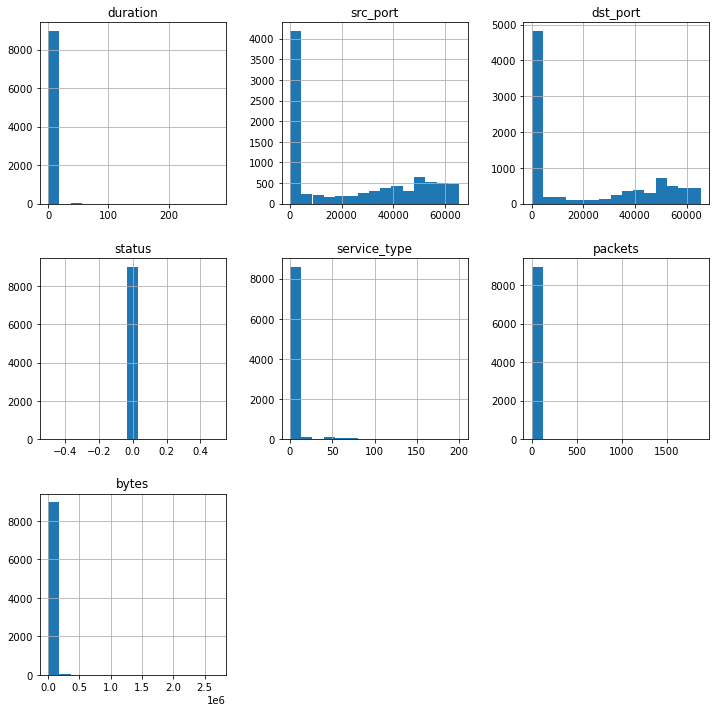

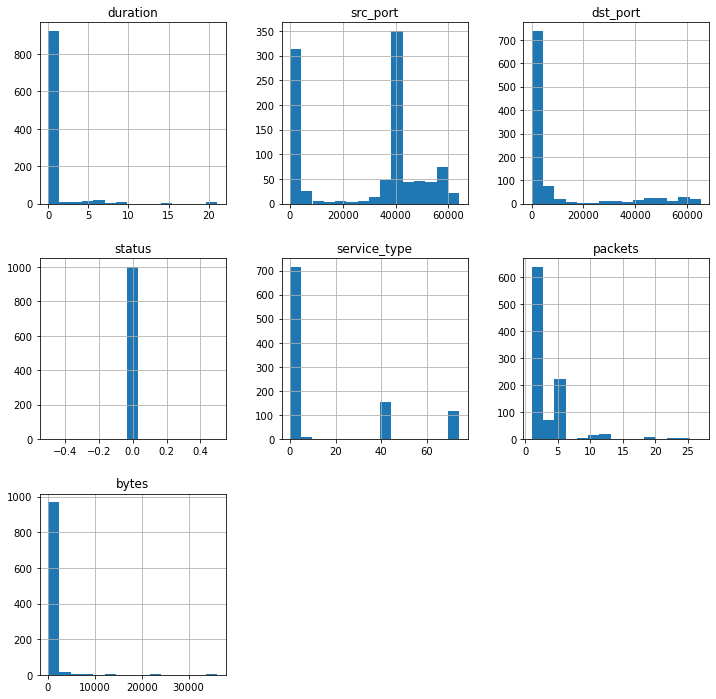

In [11]:
test_df[test_df.attack == "background"].hist(bins=15, figsize=(12, 12))
test_df[test_df.attack != "background"].hist(bins=15, figsize=(12, 12))

## Data Cleaning

In [12]:
# We drop 'status' column as we saw that there is only one value accepted all datasets
# We also drop 'packets' column as it is redoundant with the 'bytes' column

train_df.drop(['status'], axis=1, inplace=True)
test_df.drop(['status'], axis=1, inplace=True)

print(f'Number of missing values in the train dataset: {train_df.isnull().values.sum()}')
print(f'Number of missing values in the test dataset: {test_df.isnull().values.sum()}')

Number of missing values in the train dataset: 0
Number of missing values in the test dataset: 0


In [13]:
def encode_dataframes(train_df, test_df):
    """
    Encode the training and testing dataframes to have better performance in our algorithms.
    """
    train_df = train_df.drop(['attack'], axis=1)
    test_df = test_df.drop(['attack'], axis=1)

    # Convert timestamp to epoch integer, we dont keep the date values to not have biaised models later
    train_df.end_epoch = pd.to_datetime(train_df.end_epoch).apply(lambda x: x.strftime('%H%M%S')).astype(np.int64)
    test_df.end_epoch = pd.to_datetime(test_df.end_epoch).apply(lambda x: x.strftime('%H%M%S')).astype(np.int64)

    # Convert IPs to int, for optimization purpose only
    train_df.src_ip = train_df.src_ip.apply(lambda x: np.int64(ipaddress.IPv4Address(x)))
    train_df.dst_ip = train_df.dst_ip.apply(lambda x: np.int64(ipaddress.IPv4Address(x)))
    test_df.src_ip = test_df.src_ip.apply(lambda x: np.int64(ipaddress.IPv4Address(x)))
    test_df.dst_ip = test_df.dst_ip.apply(lambda x: np.int64(ipaddress.IPv4Address(x)))

    encoded_train_df = pd.get_dummies(train_df)
    encoded_test_df = pd.get_dummies(test_df)

    # Add missing columns to each dataset for consistency
    for column in encoded_train_df.columns:
        if column not in encoded_test_df.columns:
            encoded_test_df[column] = 0

    for column in encoded_test_df.columns:
        if column not in encoded_train_df.columns:
            encoded_train_df[column] = 0
    
    # Reorder columns order, also for consistency
    encoded_test_df = encoded_test_df[encoded_train_df.columns]

    return encoded_train_df, encoded_test_df

encoded_train_df, encoded_test_df = encode_dataframes(train_df, test_df)
encoded_train_df.head()

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,service_type,packets,bytes,protocol_ESP,...,flags_.A.RS.,flags_.A.RSF,flags_.AP...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF
0,216,0.996,719036146,1010349080,33421,80,0,6,437,0,...,0,0,0,0,0,1,0,0,0,0
1,216,0.852,719036146,1010349080,35297,443,0,52,3030,0,...,0,0,0,0,0,1,0,0,0,0
2,217,0.936,1010349080,719036146,80,33421,0,4,565,0,...,0,0,0,0,0,1,0,0,0,0
3,217,0.804,1010349080,719036146,443,35297,0,72,86267,0,...,0,0,0,0,0,1,0,0,0,0
4,230,0.000,719034610,1489856190,38531,25,0,1,60,0,...,0,0,0,0,0,0,0,0,0,0


## Dataset Visualisation

In [14]:
def show_flow_exchanges_3d(df, df_attack, x_axis, y_axis, z_axis, title):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    df_attacks = df[df_attack != "background"]
    xa = df_attacks[x_axis]
    ya = df_attacks[y_axis]
    za = df_attacks[z_axis]
    
    ax.scatter3D(np.log10(xa + 0.1), np.log10(ya + 0.1), np.log10(za + 0.1), label="attack", color="r", marker=".", s=15)

    df_genuines = df[df_attack == "background"]
    xg = df_genuines[x_axis]
    yg = df_genuines[y_axis]
    zg = df_genuines[z_axis]
    
    ax.scatter3D(np.log10(xg + 0.1), np.log10(yg + 0.1), np.log10(zg + 0.1), label="background", color="b", marker=".", s=15)

    ax.set_title(title, size=16)
    ax.set_xlabel('log$_{10}$ (' + x_axis + ')', size=14)
    ax.set_ylabel('log$_{10}$ (' + y_axis + ')', size=14)
    ax.set_zlabel('log$_{10}$ (' + z_axis + ')', size=14)
    
    plt.legend()

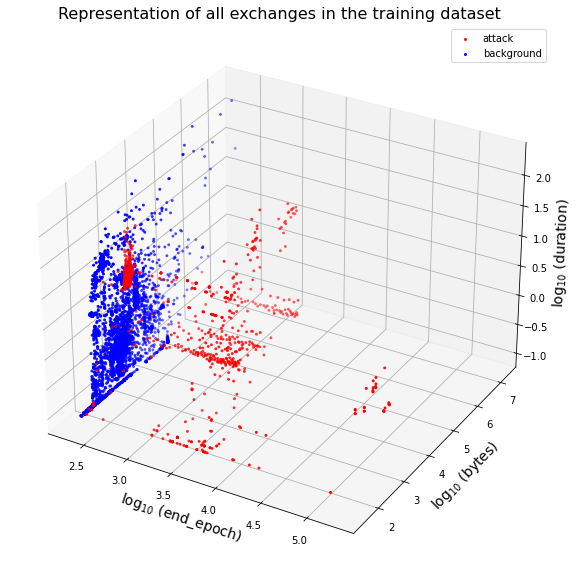

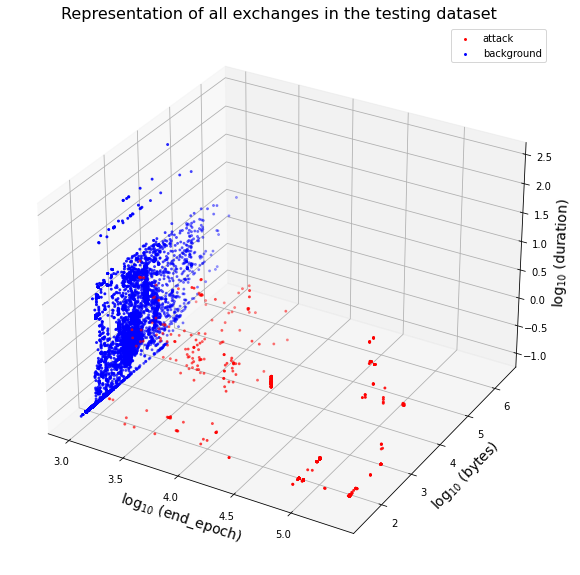

In [15]:
# End epoch differs a lot between attacks and normal flows
show_flow_exchanges_3d(encoded_train_df, train_df["attack"], 'end_epoch', 'bytes', 'duration', 'Representation of all exchanges in the training dataset')
show_flow_exchanges_3d(encoded_test_df, test_df["attack"], 'end_epoch', 'bytes', 'duration', 'Representation of all exchanges in the testing dataset')

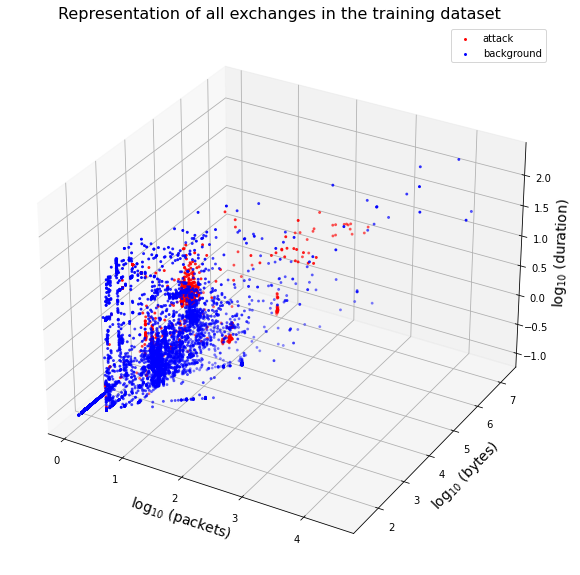

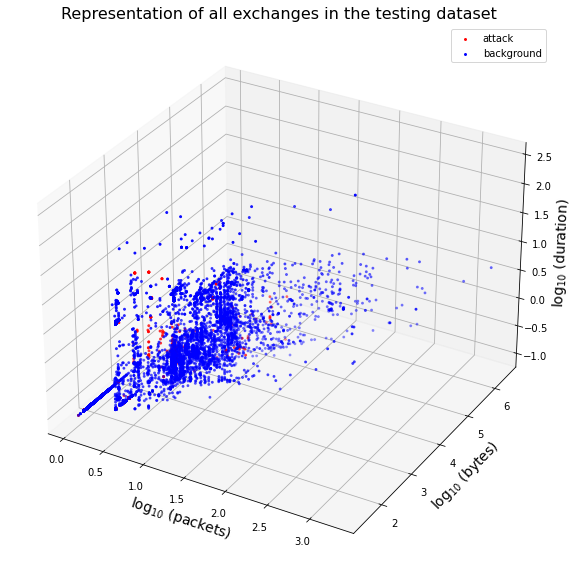

In [16]:
# Packets differs a bit between attacks and normal flows
show_flow_exchanges_3d(encoded_train_df, train_df["attack"], 'packets', 'bytes', 'duration', 'Representation of all exchanges in the training dataset')
show_flow_exchanges_3d(encoded_test_df, test_df["attack"], 'packets', 'bytes', 'duration', 'Representation of all exchanges in the testing dataset')

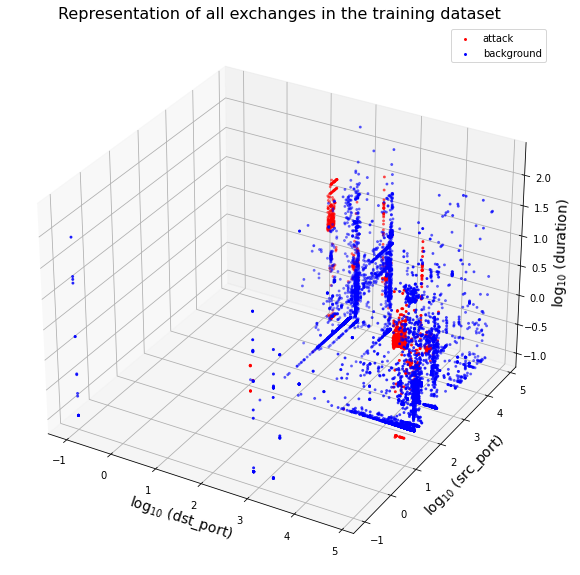

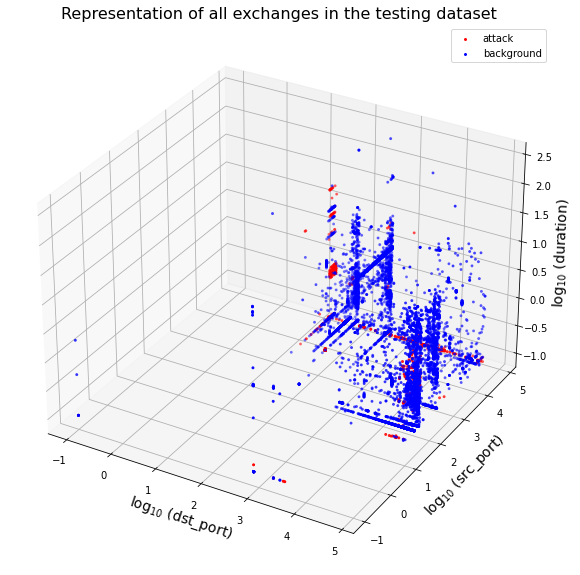

In [17]:
# Attacks seems to be focused on a reduced set of source / destination ports.
show_flow_exchanges_3d(encoded_train_df, train_df["attack"], 'dst_port', 'src_port', 'duration', 'Representation of all exchanges in the training dataset')
show_flow_exchanges_3d(encoded_test_df, test_df["attack"], 'dst_port', 'src_port', 'duration', 'Representation of all exchanges in the testing dataset')

In [18]:
# Matrix de correlation
corr = train_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,duration,src_port,dst_port,service_type,packets,bytes
duration,1.000000,0.021001,-0.024122,-0.006002,0.341391,0.301865
src_port,0.021001,1.000000,-0.783846,-0.000499,0.000116,-0.029644
dst_port,-0.024122,-0.783846,1.000000,-0.089681,0.019937,0.037410
service_type,-0.006002,-0.000499,-0.089681,1.000000,-0.009420,-0.010012
packets,0.341391,0.000116,0.019937,-0.009420,1.000000,0.510386
bytes,0.301865,-0.029644,0.037410,-0.010012,0.510386,1.000000


## Outlier detection

In [19]:
def display_metrics(y_pred):
    y_true = test_df.attack != 'background'
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Display the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=axes[0])

    # Display classifier metrics
    print(f'AUPRC: {round(average_precision_score(y_true, y_pred) * 100, 2) }%')
    print(f'Precision: {round(precision_score(y_true, y_pred) * 100, 2) }%')
    print(f'Recall: {round(recall_score(y_true, y_pred) * 100, 2) }%')
    print(f'True Negative Rate: {round( tn * 100 / (tn + fp), 2) }%')
    print(f'Accuracy: {round(accuracy_score(y_true, y_pred) * 100, 2) }%\n')

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = round(auc(fpr, tpr), 2)
    axes[1].plot([0, 1], [0, 1], color="navy", linestyle="--")
    axes[1].plot(fpr, tpr, color='darkorange', label=f'Roc curve (area = {roc_auc})')

    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.5])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Receiver operating characteristic curve')
    axes[1].legend(loc="lower right")

    # Plot Precision-Recall curve
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=axes[2])
    axes[2].set_title('Precision-Recall Curve')

#### Isolation Forests

In [20]:
classifier = IsolationForest(contamination=outlier_ratio, n_estimators=1000, random_state=rng).fit(encoded_train_df.values)
y_pred = classifier.predict(encoded_test_df.values)

df_outliers = encoded_test_df.copy()
df_outliers['if_outliers'] = [i == -1 for i in  y_pred]
df_outliers.head()

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,service_type,packets,bytes,protocol_ESP,...,flags_.A.RSF,flags_.AP...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF,if_outliers
0,1103,8.152,1167153979,719035603,38490,443,40,13,1620,0,...,0,0,0,0,0,0,0,1,0,True
1,1107,4.372,1167153979,719035603,40516,443,40,11,1502,0,...,0,0,0,1,0,0,0,0,0,False
2,1132,0.000,1167153979,719035603,40516,443,40,2,135,0,...,0,0,0,0,0,1,0,0,0,False
3,1136,4.464,1167153979,719035603,51560,443,40,10,1439,0,...,0,0,0,1,0,0,0,0,0,True
4,1149,0.000,1167153979,719035603,51560,443,40,2,135,0,...,0,0,0,0,0,1,0,0,0,True


AUPRC: 40.99%
Precision: 47.79%
Recall: 82.02%
True Negative Rate: 90.03%
Accuracy: 89.23%



AttributeError: type object 'PrecisionRecallDisplay' has no attribute 'from_predictions'

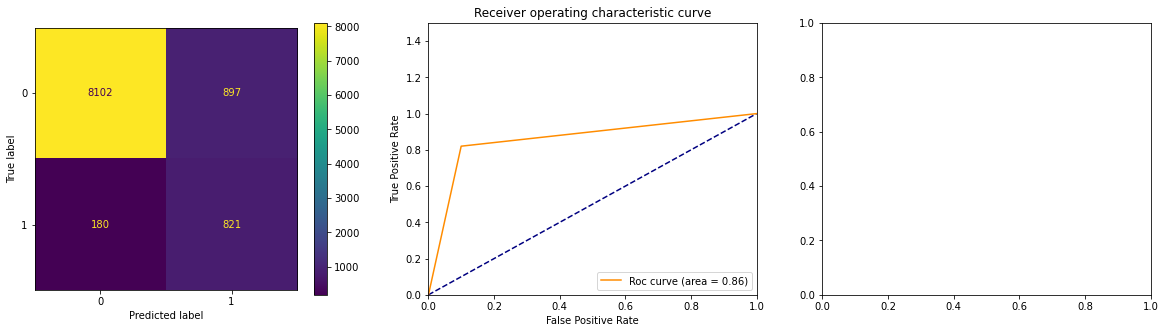

In [21]:
display_metrics(df_outliers["if_outliers"])

#### Elliptic Envelope

In [23]:
robustCovariance = EllipticEnvelope(contamination=outlier_ratio, random_state=rng).fit(encoded_train_df.values)
rc_outliers = robustCovariance.predict(encoded_test_df.values)

df_outliers['rc_outliers'] = [i == -1 for i in  rc_outliers]
df_outliers.head()

D:\Users\hugol\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,service_type,packets,bytes,protocol_ESP,...,flags_.AP...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF,if_outliers,rc_outliers
0,1103,8.152,1167153979,719035603,38490,443,40,13,1620,0,...,0,0,0,0,0,0,1,0,True,False
1,1107,4.372,1167153979,719035603,40516,443,40,11,1502,0,...,0,0,1,0,0,0,0,0,False,False
2,1132,0.000,1167153979,719035603,40516,443,40,2,135,0,...,0,0,0,0,1,0,0,0,False,False
3,1136,4.464,1167153979,719035603,51560,443,40,10,1439,0,...,0,0,1,0,0,0,0,0,True,False
4,1149,0.000,1167153979,719035603,51560,443,40,2,135,0,...,0,0,0,0,1,0,0,0,True,False


AUPRC: 39.71%
Precision: 42.08%
Recall: 92.61%
True Negative Rate: 85.82%
Accuracy: 86.5%



AttributeError: type object 'PrecisionRecallDisplay' has no attribute 'from_predictions'

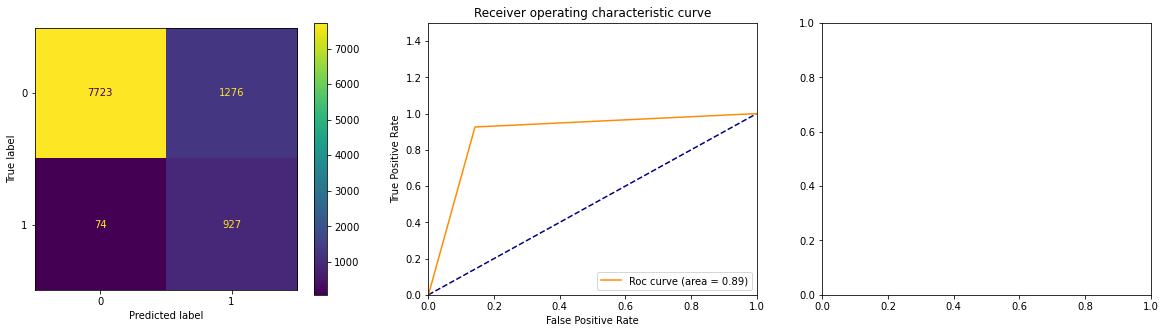

In [24]:
display_metrics(df_outliers["rc_outliers"])

#### Local Outlier Factor

In [26]:
localOutlierFactor = LocalOutlierFactor(contamination=outlier_ratio, n_neighbors=1000, n_jobs=-1)

lof_outliers = localOutlierFactor.fit_predict(encoded_test_df.values)

df_outliers['lof_outliers'] = [i == -1 for i in lof_outliers]
df_outliers.head()

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,service_type,packets,bytes,protocol_ESP,...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF,if_outliers,rc_outliers,lof_outliers
0,1103,8.152,1167153979,719035603,38490,443,40,13,1620,0,...,0,0,0,0,0,1,0,True,False,True
1,1107,4.372,1167153979,719035603,40516,443,40,11,1502,0,...,0,1,0,0,0,0,0,False,False,True
2,1132,0.000,1167153979,719035603,40516,443,40,2,135,0,...,0,0,0,1,0,0,0,False,False,True
3,1136,4.464,1167153979,719035603,51560,443,40,10,1439,0,...,0,1,0,0,0,0,0,True,False,True
4,1149,0.000,1167153979,719035603,51560,443,40,2,135,0,...,0,0,0,1,0,0,0,True,False,True


In [25]:
display_metrics(df_outliers["lof_outliers"])

KeyError: 'lof_outliers'

#### Algorithm comparison

In [27]:
df_outliers.head()

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,service_type,packets,bytes,protocol_ESP,...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF,if_outliers,rc_outliers,lof_outliers
0,1103,8.152,1167153979,719035603,38490,443,40,13,1620,0,...,0,0,0,0,0,1,0,True,False,True
1,1107,4.372,1167153979,719035603,40516,443,40,11,1502,0,...,0,1,0,0,0,0,0,False,False,True
2,1132,0.000,1167153979,719035603,40516,443,40,2,135,0,...,0,0,0,1,0,0,0,False,False,True
3,1136,4.464,1167153979,719035603,51560,443,40,10,1439,0,...,0,1,0,0,0,0,0,True,False,True
4,1149,0.000,1167153979,719035603,51560,443,40,2,135,0,...,0,0,0,1,0,0,0,True,False,True


In [31]:
df_outliers["Attack"] = test_df.attack != "background"

In [32]:
df_outliers.head()

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,service_type,packets,bytes,protocol_ESP,...,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF,if_outliers,rc_outliers,lof_outliers,Attack
0,1103,8.152,1167153979,719035603,38490,443,40,13,1620,0,...,0,0,0,0,1,0,True,False,True,True
1,1107,4.372,1167153979,719035603,40516,443,40,11,1502,0,...,1,0,0,0,0,0,False,False,True,True
2,1132,0.000,1167153979,719035603,40516,443,40,2,135,0,...,0,0,1,0,0,0,False,False,True,True
3,1136,4.464,1167153979,719035603,51560,443,40,10,1439,0,...,1,0,0,0,0,0,True,False,True,True
4,1149,0.000,1167153979,719035603,51560,443,40,2,135,0,...,0,0,1,0,0,0,True,False,True,True


### Number of attacks detected as outliers by all algorithms

In [37]:
len(df_outliers[(df_outliers['Attack'] == True) & (df_outliers['if_outliers'] == True) & (df_outliers['lof_outliers'] == True) & (df_outliers['rc_outliers'] == True)])

202

### Number of attacks detected as outliers by LOF and RC

In [44]:
len(df_outliers[(df_outliers['Attack'] == True) & (df_outliers['lof_outliers'] == True) & (df_outliers['rc_outliers'] == True)])

203

### Number of attacks detected as outliers by RC and IF

In [45]:
len(df_outliers[(df_outliers['Attack'] == True) & (df_outliers['if_outliers'] == True) & (df_outliers['rc_outliers'] == True)])

770

### Number of attacks detected as outliers by LOF and IF

In [ ]:
len(df_outliers[(df_outliers['Attack'] == True) & (df_outliers['if_outliers'] == True) & (df_outliers['lof_outliers'] == True)])

244

### Number of attacks detected as outliers by LOF

In [48]:
len(df_outliers[(df_outliers['Attack'] == True) & (df_outliers['lof_outliers'] == True)])

258

### Number of attacks detected as outliers by IF

In [49]:
len(df_outliers[(df_outliers['Attack'] == True) & (df_outliers['if_outliers'] == True)])

821

### Number of attacks detected as outliers by RC

In [50]:
len(df_outliers[(df_outliers['Attack'] == True) & (df_outliers['rc_outliers'] == True)])

927

### Number of background detected as outliers by all algorithms

In [41]:
len(df_outliers[(df_outliers['Attack'] == False) & (df_outliers['if_outliers'] == True) & (df_outliers['lof_outliers'] == True) & (df_outliers['rc_outliers'] == True)])

68